# Robust PCA for Image Denoising

Similar to regression, classical PCA is very sensitive to outliers and can lead to misleading conclusions in the presence of outliers. This is why we use Robust PCA which reduces dimensions by finding a low-rank representation of our data. 

Assume the following:

    - M is the observed data matrix
    - L is the low-rank matrix (to be estimated)
    - S is a matrix of sparse outliers (to be estimated)
    
$$ M = L + S $$

We want to $$\min{(rank(L) + \lambda ||S||_0)}$$ 

subject to M = L+S, but that objective function is not convex, so using convex relaxation and Augmented Lagrangian Multipliers, we can rewrite the function as:

$$l(L,S,Y;\mu) = ||L||_* + \lambda||S||_1 + \frac{\mu}{2}||M-L-S+\frac{Y}{\mu}||^2_F+\frac{\mu}{2}||\frac{Y}{\mu}||^2_F$$

We can use solve the Augmented Lagrangian Multiplier function above using the following steps:

1. Initialize S0, Y0, L0 = 0

2. while the algorithm hasn't converged do:

    Compute $L_{k+1} = D_{\mu}(M_{1/\mu}-S_k-\frac{Y_k}{\mu})$ (solved by minimizing with respect to L and Single Value Thresholding )
    
    Compute $S_{k+1} = S_{\lambda\mu}(M_{\lambda/\mu}-L_{k+1}-\frac{Y_k}{\mu})$ (solved by minimizing with respect to S and soft-thresholding )
    
    Compute $Y_{k+1} = Y_k + \mu(M - L_{k+1} - S_{k+1})$

3. end while

In [25]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [326]:
def RPCA(M, lam, mu):
    
    n = M.shape[0]
    m = M.shape[1]

    L = np.zeros((n, m))
    S = np.zeros((n, m))
    Y = np.zeros((n, m))

    # Y is Lagrangian multiplier for each pixel constant that the
    # reconstructed values must match

    L0 = L
    S0 = S

    mu_bar = mu*1e7
    d_norm = np.linalg.norm(M, 'fro')
    rho = 1.5
    converged = False
    stopCriterion = 1
    tol = 1e-5

    #while block coordinate descent hasn't converged
    while not converged:

        #update L; minimize objective function with respect to L 
        #given S and Y, update L
        #argmin(L) = ||L||_* + mu/2||M - L - S + Y/mu||^2
        #let X = M - L + Y\mu
        #L = D(X) = U*S(sigma)*V
        X = M - S + Y/mu
        u, s, vh = np.linalg.svd(X)
        s_t = np.diag(np.maximum(s-1/mu, 0))
        L = (u @ s_t @ vh[:n, :])


        #update S; minimize objective function with respect to L 
        #given L and Y, update S
        #argmin(S) = lambda*||S||_1 + mu/2||M - L - S + Y/mu||^2
        #let X = M - L + Y/mu
        X = M - L + Y/mu
        S = (np.sign(X)*np.maximum(np.abs(X)-lam/mu, 0))

        #update Y
        Y = Y + mu * (M - L - S)
        mu = min(mu*rho, mu_bar)

        #stop condition
        stopCriterion = np.linalg.norm(M - L - S, 'fro') / d_norm
        if stopCriterion < tol:
            converged = True
    
    return L, S

In general, we set large tau (accordingly, $\frac{1}{\mu}$) to embed the low-rank property. This is to 'kill' (as quoted by ref [1] A Singular Value Thresholding Algorithm For Matrix Completion, Jian-feng Cai, Emmanuel J. Candes, and Zuowei Shen) most of the small singular values and produces a low-rank output.

Similarly, the $\lambda$ term penalizes the values of the sparse matrix S. The larger we set $\lambda$, the less significant S is.  

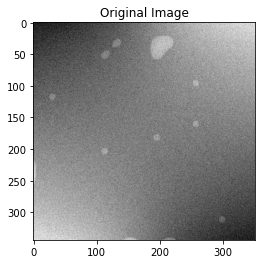

In [327]:
#apply the algorithm on the noisy image data
img = scipy.io.loadmat('Image_anomaly.mat')["X"]
M = img.copy()

#print the original image
plt.figure()
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.show()

In [334]:
L, S = RPCA(M, 0.01, 0.01)

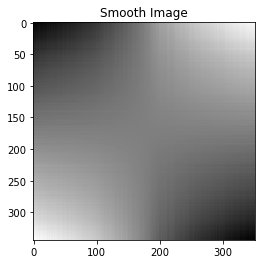

In [335]:
#low rank representation of our original image without the outliers
#important features preserved from high dimensional to low rank
plt.figure()
plt.imshow(L, cmap='gray')
plt.title("Smooth Image")
plt.show()

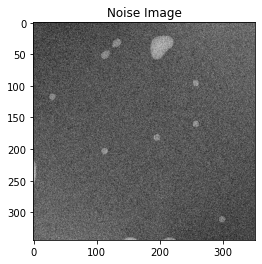

In [336]:
#outlier matrix
plt.figure()
plt.imshow(S, cmap='gray')
plt.title("Noise Image")
plt.show()

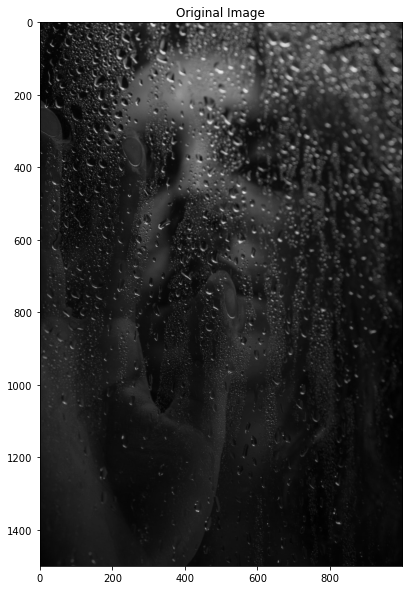

In [337]:
#apply the algorithm on the noisy image data
img = PIL.Image.open('rain2.jpeg')
img = img.convert("L")
img = np.array(img)
n = img.shape[0]
m = img.shape[1]
M = img.copy()

#print the original image
plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.show()

In [338]:
L1, S1 = RPCA(M.T, 0.01, 0.00001)

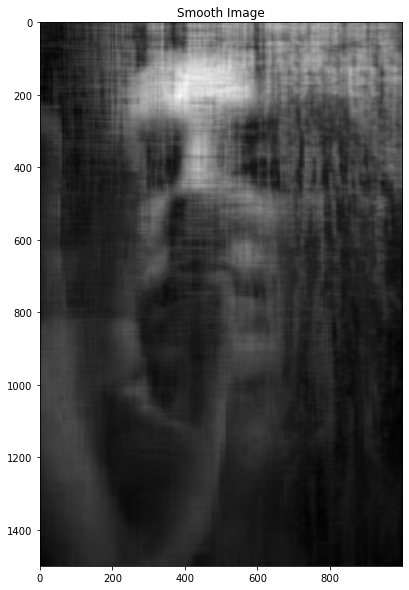

In [339]:
#low rank representation of our original image without the outliers
#important features preserved from high dimensional to low rank
plt.figure(figsize = (10,10))
plt.imshow(L1.T, cmap='gray')
plt.title("Smooth Image")
plt.show()

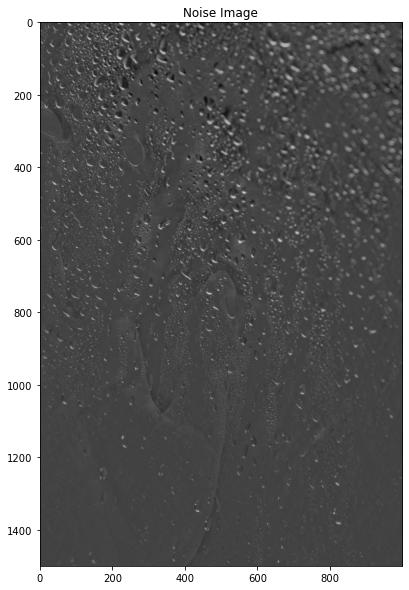

In [340]:
#outlier matrix
plt.figure(figsize = (10,10))
plt.imshow(S1.T, cmap='gray')
plt.title("Noise Image")
plt.show()

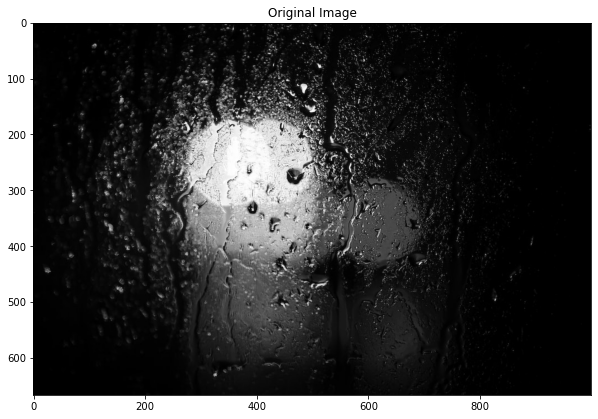

In [341]:
#apply the algorithm on the noisy image data
img = PIL.Image.open('rain.jpeg')
img = img.convert("L")
img = np.array(img)
n = img.shape[0]
m = img.shape[1]
M = img.copy()

#print the original image
plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.show()

In [342]:
L2, S2 = RPCA(M, 0.01, 0.0001)

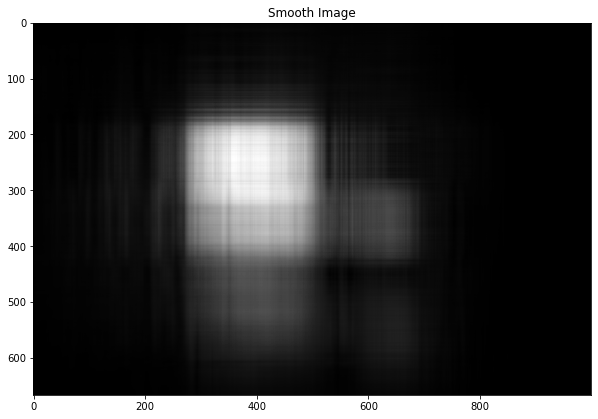

In [343]:
#low rank representation of our original image without the outliers
#important features preserved from high dimensional to low rank
plt.figure(figsize = (10,10))
plt.imshow(L2, cmap='gray')
plt.title("Smooth Image")
plt.show()

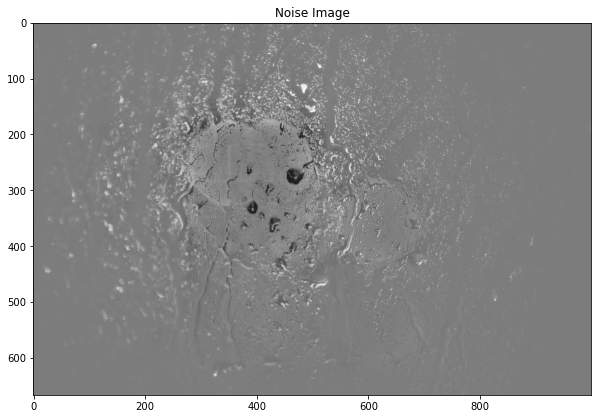

In [344]:
#outlier matrix
plt.figure(figsize = (10,10))
plt.imshow(S2, cmap='gray')
plt.title("Noise Image")
plt.show()

As you can see from the images above, Robust Principal Component Analysis is able to effectively distinguish the noise in the image and smoothen the original noisy image.